# Enter

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.api as sma
from statsmodels.regression.linear_model import OLS
from scipy.stats import kurtosis, skew                                          #檢驗殘差常態性
from statsmodels.stats.stattools import durbin_watson                           #檢驗殘差變異數獨立性
from sklearn import preprocessing                                               #檢驗變異數同值性
from statsmodels.stats.outliers_influence import variance_inflation_factor      #檢驗共線性
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
df = pd.read_excel("/Users/chouhouren/Desktop/論文資料_新/建模型資料/df_實際模型.xlsx")

df = df.dropna()

df = df.drop(['編號'], axis=1)

df = pd.DataFrame(df)

df.columns

Index(['新總價', '新面積', '屋齡', '移轉層次', '總樓層數', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛',
       '102上', '102下', '103上', '103下', '104上', '104下', '105上', '105下', '106上',
       '106下', '公寓(5樓含以下無電梯)', '華廈(10層含以下有電梯)', '住宅大樓(11層含以上有電梯)', 'RB', 'RC',
       'SRC/SC', '新交易車位數', '平面車位', '機械車位', '其他車位', '士林區', '大同區', '大安區', '中山區',
       '中正區', '內湖區', '文山區', '北投區', '松山區', '南港區', '萬華區', '信義區', '大公園最近實際距離',
       '捷運站出口最近實際距離', '明星國中近實際距離', '明星國小最近實際距離', '百貨公司最近實際距離', '鄰里公園最近實際距離',
       '體育館最近實際距離', '加油站', '電塔', '污水處理廠', '垃圾焚化廠', '飛機場', '變電所', '殯儀館', '醫院'],
      dtype='object')

In [30]:
feture =[]
feture = df.drop(['新總價','103上','住宅大樓(11層含以上有電梯)','內湖區'], axis=1)#去掉多餘虛擬變數
x = feture
y = df.新總價


In [31]:
def stepwise_selection(x, y, 
                       initial_list=[],
                       vif_value=[],
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       vif_out=10,
                       verbose=True):
    
    included = list(x.columns)
    vif_too_big=list(vif_value)
    while True:
        changed=False
        
        excluded = list(set(x.columns)-set(included)-set(vif_too_big))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        if pvalues.max()>0.05:
            changed=True
            worst_feature = pvalues[pvalues > 0.05].index
            for bad_feature in worst_feature:
                included.remove(bad_feature)
                

        
        vif_constant = sm.add_constant(x[included])        
        f_vif=[variance_inflation_factor(vif_constant.values, j) for j in range(vif_constant.shape[1])]
        f_vif=pd.Series(f_vif,index=vif_constant.columns)
        f_vif=f_vif.iloc[1:]
        big_vif = f_vif.max()
            
            
        if big_vif > vif_out:
            changed=True
            big_vif_feature = f_vif.idxmax()
            included.remove(big_vif_feature)
            vif_too_big.append(big_vif_feature)
            #if verbose:
                #print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        
         
        if not changed:
            break
    return included

result = stepwise_selection(x, y)
len(result)

30

drop_feature = list(set(df.columns)-set(df[result].columns))


drop_feature = pd.DataFrame(drop_feature)

drop_feature.to_excel('實際enter刪除的因子.xlsx')

# 全部輸入OLS模型

In [32]:
x_train = sma.add_constant(df[result]) ## let's add an intercept (beta_0) to our model

Enter_model = sm.OLS(y,x_train).fit()



#### 輸出係數、P值、VIF

#### 常態性假設檢驗

In [33]:
e=y-Enter_model.fittedvalues
resid_skew = skew(e)
resid_kurtosis = kurtosis(e)
print('{:40}{:.5}'.format('skewness of normal distribution:',resid_skew ))
print('{:40}{:.5}'.format('kurtosis of normal distribution:',resid_kurtosis ))

skewness of normal distribution:        0.095154
kurtosis of normal distribution:        1.254


#### 獨立性假設檢驗

In [34]:
def dw(data):
    ols_res = OLS(data, np.ones(len(data))).fit()
    return durbin_watson(ols_res.resid)


print('{:20}{:.5}'.format('Durbin-Watson:',dw(e)))

Durbin-Watson:      1.9083


#### 變異數同值性假設檢驗

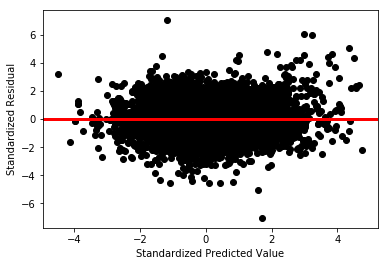

In [35]:
y_pred_norm=preprocessing.scale(Enter_model.fittedvalues)

e_norm =preprocessing.scale(e)


plt.scatter(y_pred_norm, e_norm,color='k',marker='o')
plt.xlabel("Standardized Predicted Value")
plt.ylabel("Standardized Residual")
plt.axhline(y=0,linewidth=3, color='r')
plt.show()

#### 無共線性檢驗

In [36]:
VIF_check=[variance_inflation_factor(x_train.values, j) for j in range(x_train.shape[1])]
VIF_check=pd.DataFrame(VIF_check,index=x_train.columns,columns=['VIF'])


VIF_check=VIF_check.drop(['const'])
if VIF_check['VIF'].max() <10:
    print('no collinarity')
else:
    print(VIF_check['VIF'].argmax())
    
VIF_check

no collinarity


,VIF
新面積,1.938409
屋齡,2.180125
移轉層次,1.852538
總樓層數,2.629884
建物現況格局-房,1.596027
104下,1.105903
105上,1.096300
105下,1.095270
106上,1.098324
106下,1.036538


# K-Fold Regression Model

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.utils import check_array
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [38]:
x = np.array(df[result])
y = np.array(df['新總價'])
x = np.array([np.concatenate((v,[1])) for v in x])

In [39]:
linreg = LinearRegression(fit_intercept=False)

In [40]:
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    linreg.fit(x[train],y[train])
    p = linreg.predict(x[test])
    e = p-y[test]

In [41]:
y_test=np.exp(y[test])
p = np.exp(p)

#### MAPE

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE=mean_absolute_percentage_error(y_test,p).round(2)

#### MAE

In [43]:
MAE=mean_absolute_error(y_test, p).round(2)

#### RMSE

In [44]:
RMSE=np.sqrt(metrics.mean_squared_error(y_test,p)).round(0)

#### HIT RATE

In [45]:
def Hit_Rate_error(y_test,predict_value,alpha):
    
    df_yp=[]
    y_test=pd.DataFrame(y_test,columns=['y_test'])
    predict_value=pd.DataFrame(predict_value,columns=['predict_value'])
    df_yp = pd.concat([y_test,predict_value],axis=1)#y_test and predict_value
    命中值 =[(df_yp['predict_value']<df_yp['y_test']+df_yp['y_test']*alpha)&(df_yp['predict_value']>df_yp['y_test']-df_yp['y_test']*alpha)]
    choices = [1]
    df_yp['命中值'] = np.select(命中值,choices,default=0)
    HIT_rate = (df_yp['命中值'].sum()/len(y_test)*100).round(2)
    return HIT_rate

In [46]:
HIT_rate_10=Hit_Rate_error(y_test,p,0.1)

In [47]:
HIT_rate_20=Hit_Rate_error(y_test,p,0.2)

In [48]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, p).round(2)

In [49]:
print('{:20}{:.4}'.format('R2:', R2))
print('{:20}{:.10}'.format('MAPE:', MAPE))
print('{:20}{:.10}'.format('MAE:', MAE))
print('{:20}{:.10}'.format('RMSE:', RMSE))
print('{:20}{:.10}'.format('HIT_rate_10:', HIT_rate_10))
print('{:20}{:.10}'.format('HIT_rate_20:', HIT_rate_20))

R2:                 0.85
MAPE:               15.98
MAE:                4889172.29
RMSE:               12631827.0
HIT_rate_10:        38.25
HIT_rate_20:        70.12
